In [1]:
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
#!pip install networkx

In [3]:
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [4]:
shapes = pd.read_csv('GTFS_INTEGRA_SALVADOR2/shapes.txt', sep=',')
shapes.head()

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  shape_dist_traveled
0  26082_I    -12.931634    -38.444313                  0                  NaN
1  26082_I    -12.931602    -38.444294                  1                  NaN
2  26082_I    -12.931561    -38.444290                  2                  NaN
3  26082_I    -12.931520    -38.444305                  3                  NaN
4  26082_I    -12.931504    -38.444317                  4                  NaN

In [5]:
shape_id = shapes.query(" shape_id == '50786_I' ")
shape_id

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
73356  50786_I    -12.983377    -38.511208                  0   
73357  50786_I    -12.983275    -38.511211                  1   
73358  50786_I    -12.983132    -38.511368                  2   
73359  50786_I    -12.982990    -38.511543                  3   
73360  50786_I    -12.982833    -38.511715                  4   
...        ...           ...           ...                ...   
73468  50786_I    -13.004930    -38.509014                112   
73469  50786_I    -13.005241    -38.509262                113   
73470  50786_I    -13.005454    -38.509384                114   
73471  50786_I    -13.005739    -38.509476                115   
73472  50786_I    -13.005992    -38.509468                116   

       shape_dist_traveled  
73356                  NaN  
73357                  NaN  
73358                  NaN  
73359                  NaN  
73360                  NaN  
...                    ...  
73468                  NaN  
73469                  NaN  
73470                  NaN  
73471                  NaN  
73472                  NaN  

[117 rows x 5 columns]

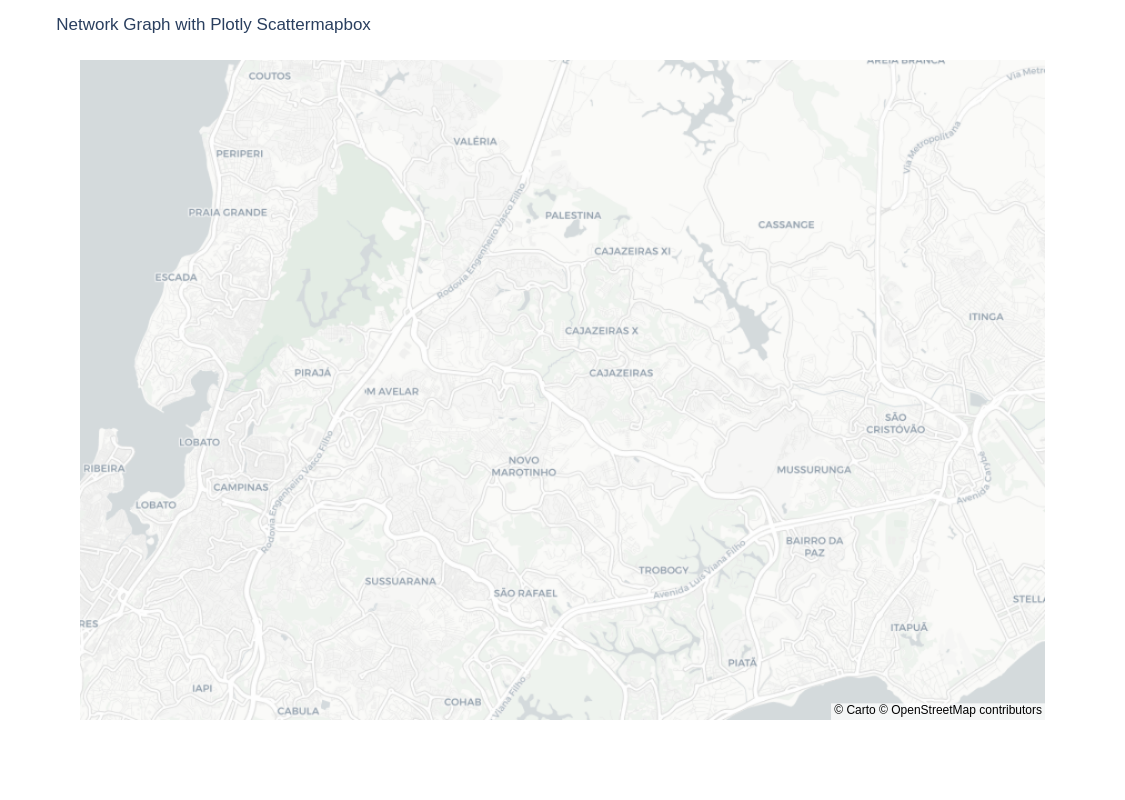

In [6]:
fig = px.scatter_mapbox(shape_id,
                        lat='shape_pt_lat',
                        lon='shape_pt_lon',
                        hover_name="shape_pt_sequence",
                        zoom=1)

fig.update_layout(
    title='Network Graph with Plotly Scattermapbox',
    showlegend=False,
    height=800,
    width=800,
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=-12.902925, lon=-38.418237), 
        zoom=12
    ),
)

fig.show()

In [7]:
gtfs = pd.read_parquet('gtfs_bus_topique_02_2024.parquet')
gtfs.head()

linha_atend linha cod_ate sentido    shape  ordem   stop_id        lat  \
0  1321_12432  1321   12432       I  12432_I      1  45833944 -12.929167   
1  1321_12432  1321   12432       I  12432_I      2  44784089 -12.926615   
2  1321_12432  1321   12432       I  12432_I      3  45833505 -12.925073   
3  1321_12432  1321   12432       I  12432_I      4  44165028 -12.923343   
4  1321_12432  1321   12432       I  12432_I      5  44783562 -12.920358   

         lon  distancias  acumulado        posicao  
0 -38.437500       0.000      0.000        inicial  
1 -38.436531       0.309      0.309  intermediario  
2 -38.439533       0.353      0.662  intermediario  
3 -38.440968       0.288      0.950  intermediario  
4 -38.442822       0.387      1.337  intermediario

In [8]:
df_line = gtfs.query(" linha == '1130' ")

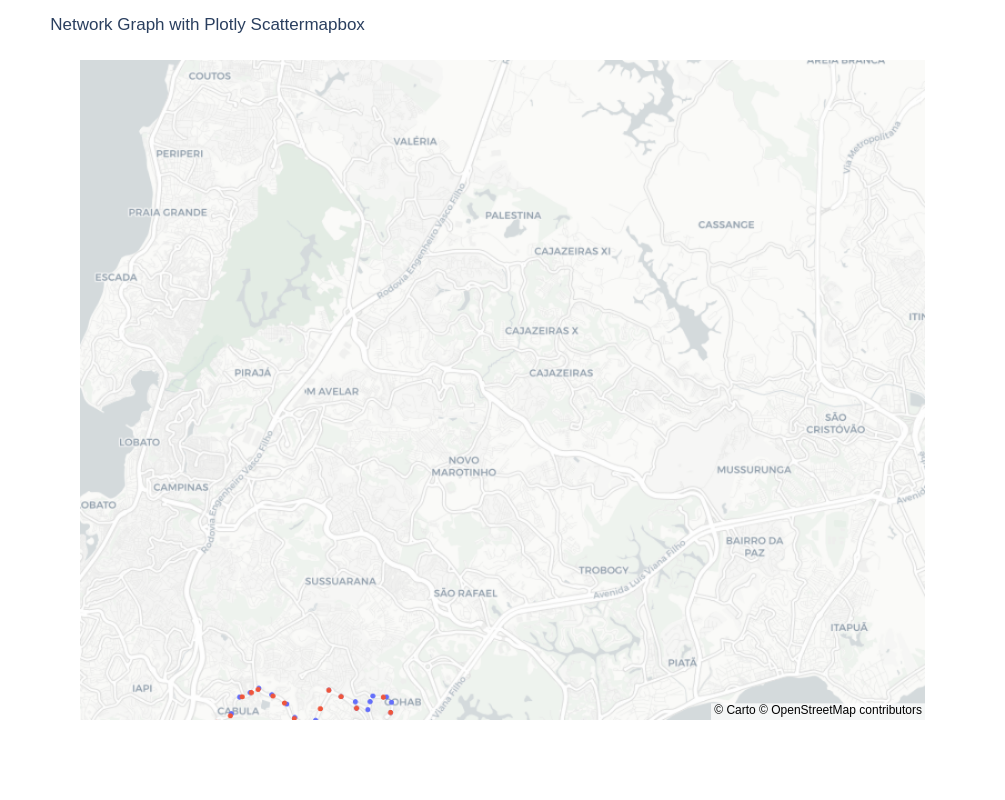

In [9]:
fig = px.scatter_mapbox(df_line,
                        lat='lat',
                        lon='lon',
                        color='sentido',
                        hover_name="ordem",
                        zoom=1)

fig.update_layout(
    title='Network Graph with Plotly Scattermapbox',
    showlegend=False,
    height=800,
    width=800,
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=-12.902925, lon=-38.418237), 
        zoom=12
    ),
)

fig.show()

In [10]:
selected_lines = gtfs.query("stop_id == '44782325' ").linha.unique()

In [11]:
cols = ['stop_id', 'lat', 'lon']
gtfs_stop_id = gtfs.pivot_table(index=cols, aggfunc=set).reset_index()[cols] 
gtfs_stop_id

stop_id        lat        lon
0     100009577 -12.901954 -38.419582
1     100722777 -12.899299 -38.407673
2     100722778 -12.896647 -38.408215
3           101 -12.930289 -38.323021
4     101214305 -12.870927 -38.433800
...         ...        ...        ...
3874   99834780 -12.937695 -38.486004
3875   99834781 -12.937044 -38.484684
3876   99834782 -12.936999 -38.484497
3877   99834783 -12.936103 -38.483089
3878   99834784 -12.935954 -38.483051

[3879 rows x 3 columns]

In [12]:
def get_cord(stop_id):
    return gtfs_stop_id.query(f" stop_id == '{stop_id}' ")[['lat', 'lon']].values[0]

In [13]:
def get_edges(dataf_shape_id_subset):
    
    dataf_shape_id_subset['dst_ordem'] = dataf_shape_id_subset['ordem'].shift(-1)
    dataf_shape_id_subset['dst']       = dataf_shape_id_subset['stop_id'].shift(-1)
    dataf_shape_id_subset['dist_edge'] = dataf_shape_id_subset['distancias'].shift(-1)

    gtfs_shape_not_na = dataf_shape_id_subset[dataf_shape_id_subset.dst.notna()]
    gtfs_shape_not_na = gtfs_shape_not_na.sort_values('ordem')
    arestas = [tuple(row) for row in list(gtfs_shape_not_na[['stop_id', 'dst']].values)]

    return arestas

In [14]:
def get_edges_df(gtfs_shape):

    
    gtfs_shape['dst_ordem'] = gtfs_shape['ordem'].shift(-1)
    gtfs_shape['dst']       = gtfs_shape['stop_id'].shift(-1)
    gtfs_shape['dist_edge'] = gtfs_shape['distancias'].shift(-1)

    gtfs_shape_not_na = gtfs_shape[gtfs_shape.dst.notna()]

    return gtfs_shape_not_na

In [15]:
#_, df_sample = get_edges(gtfs.query(" shape == '12432_I' "))

In [16]:
#df_sample

In [17]:
# Create a NetworkX graph
G = nx.DiGraph()
#for shape_id, df_shape_id in gtfs.query(" linha in @selected_lines ").groupby('shape'):
for shape_id, df_shape_id in gtfs.groupby('shape'):
    #df_shape_id = df_shape_id.sort_values('ordem')
    arestas = get_edges(df_shape_id.sort_values('ordem'))
    G.add_edges_from(arestas)

In [18]:
dfs = []
for shape_id, df_shape_id in gtfs.query(" linha in @selected_lines ").groupby('shape'):
    dfs.append(get_edges_df(df_shape_id))
df_lines = pd.concat(dfs, ignore_index=True)

In [19]:
#df_lines.query(" stop_id == '44783906' and dst == '376991599' ")
df_lines.query(" stop_id == '49053699' and dst == '44782325' ")

linha_atend   linha cod_ate sentido    shape  ordem   stop_id  \
1449  012504_69572  012504   69572       V  69572_V      2  49053699   

            lat        lon  distancias  acumulado        posicao  dst_ordem  \
1449 -12.996333 -38.447376       0.208      0.208  intermediario        3.0   

           dst  dist_edge  
1449  44782325     10.557

In [20]:
#df_lines.query(f"  ")

In [21]:
pos = {node: get_cord(node) for node in G.nodes}

In [22]:
# Draw the graph using nx.draw
#nx.draw(G, pos=pos, node_size=1, with_labels=False, node_color='lightblue', edge_color='black')

In [23]:
# contar a quantidade de shape id por linha e sentido

# gtfs_shape_id_count = gtfs.pivot_table(index=['linha', 'cod_ate', 'sentido'], 
#                                        values=['shape'], 
#                                        aggfunc=pd.Series.nunique).reset_index()

# correto, um shape_id por linha sentido
#gtfs_shape_id_count.describe()

## Matplotlib

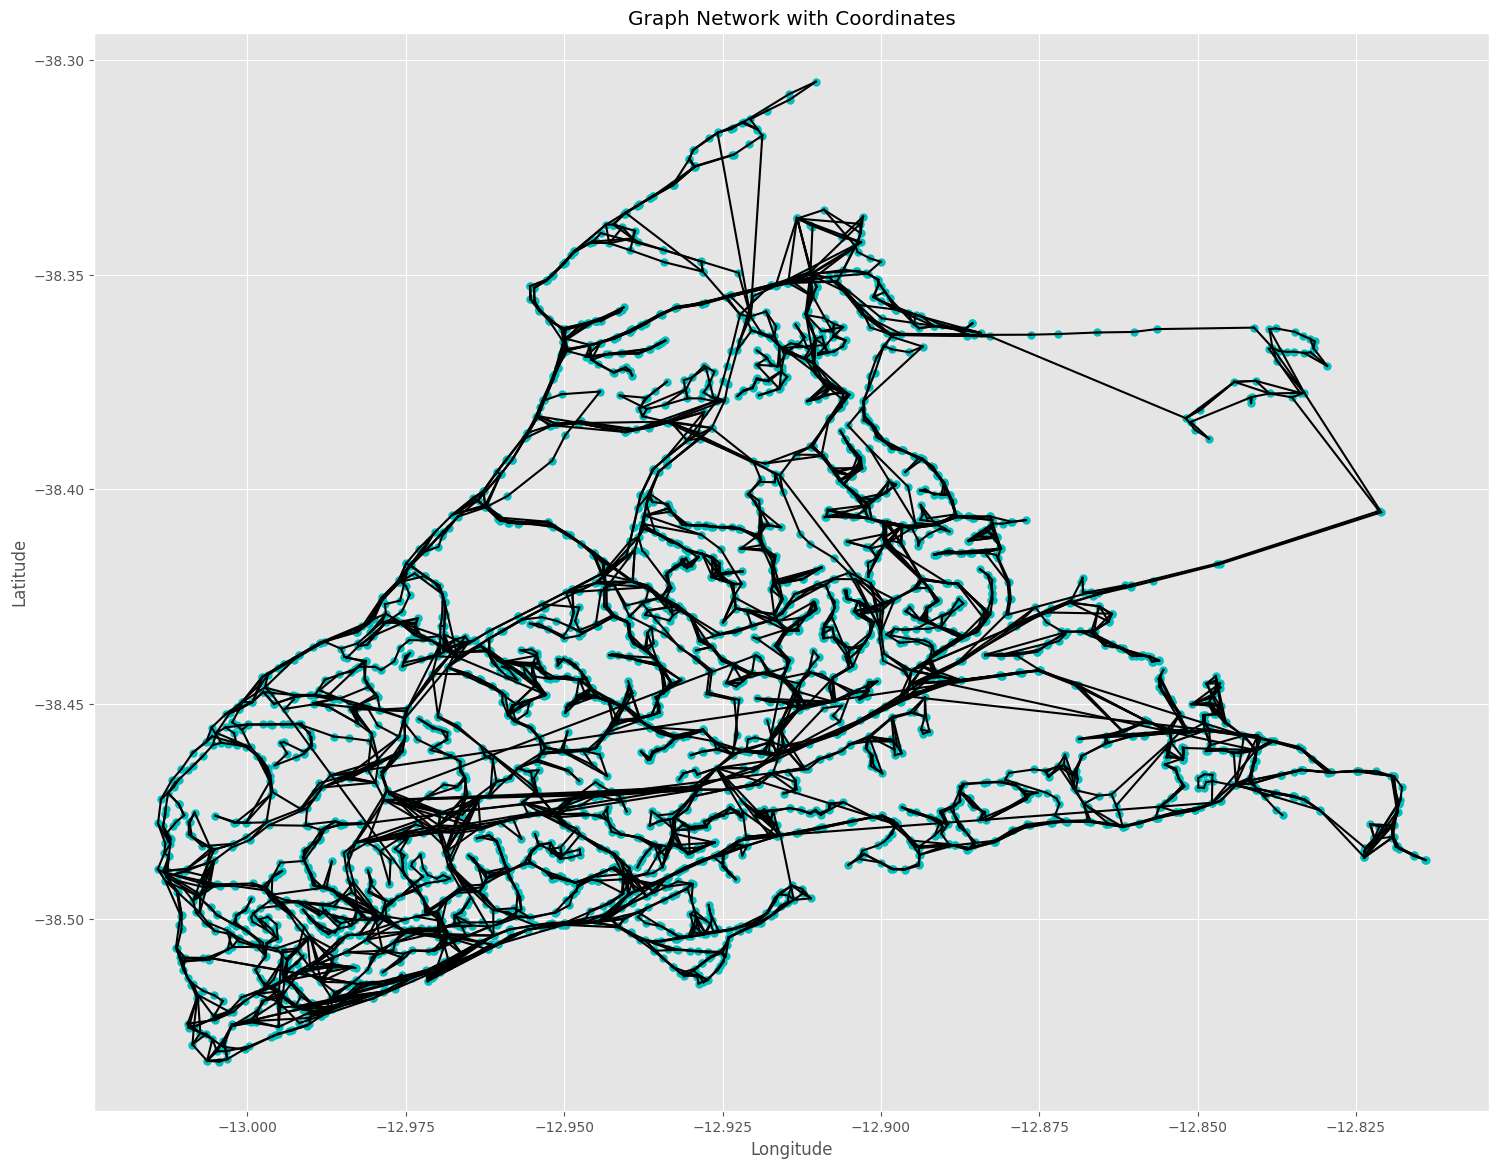

In [24]:
plt.figure(figsize=(18,14))
# Plot nodes
for node in G.nodes():
    lat, lon = pos[node]
    plt.plot(lat, lon, 'co', markersize=5)
    #plt.text(df_nodes.lon.iloc[i], df_nodes.lat.iloc[i], texto, fontsize=12)

# # Plot edges
# for edge in G.edges:
#     start_node = stop_coordinates[edge[0]]
#     end_node = stop_coordinates[edge[1]]
#     plt.plot([start_node[1], end_node[1]], 
#              [start_node[0], end_node[0]], 'k-')


registrada = []
for edge in G.edges():
    if edge not in registrada:
        lat0, lon0 = pos[edge[0]]
        lat1, lon1 = pos[edge[1]]
        
        #prin
        #edge_lat.extend([lat0, lat1, None])
        #edge_lon.extend([lon0, lon1, None])
    
        plt.plot([lat0, lat1], 
                 [lon0, lon1], 'k-')
    else:
        registrada.append(edge)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Graph Network with Coordinates')
plt.grid(True)
plt.show()

## Plotly 

In [25]:
# Crear listas para las coordenadas de los nodos
node_lat = []
node_lon = []
for node in G.nodes():
    lat, lon = pos[node]
    node_lat.append(lat)
    node_lon.append(lon)

In [26]:
# Crear listas para las aristas
edge_lat = []
edge_lon = []
for edge in G.edges():
    lat0, lon0 = pos[edge[0]]
    lat1, lon1 = pos[edge[1]]
    edge_lat.extend([lat0, lat1, None])
    edge_lon.extend([lon0, lon1, None])

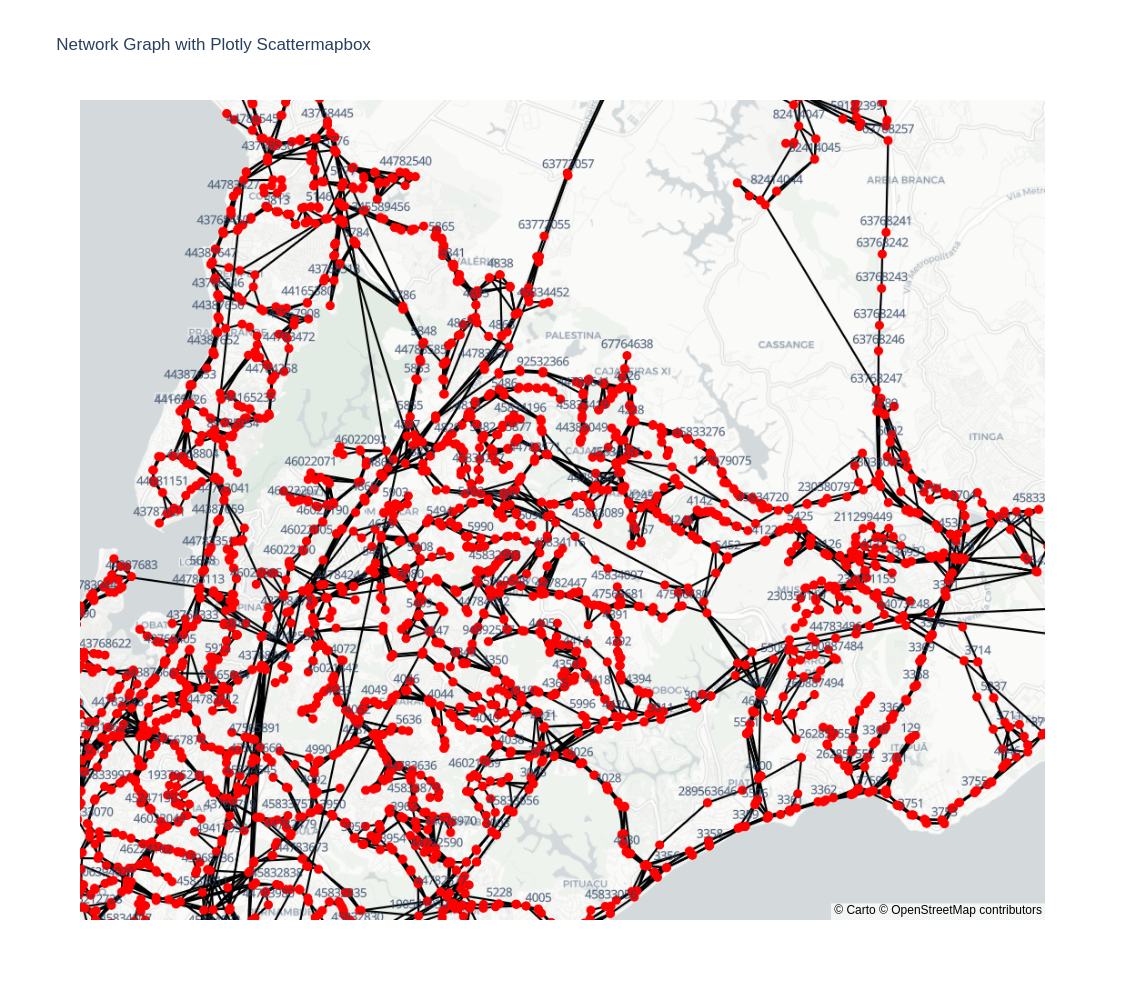

In [27]:
# Crear el trazo de las aristas
edge_trace = go.Scattermapbox(
    lat=edge_lat,
    lon=edge_lon,
    mode='lines',
    line=dict(width=2, color='black'),
    hoverinfo='none'
)

# Crear el trazo de los nodos
node_trace = go.Scattermapbox(
    lat=node_lat,
    lon=node_lon,
    mode='markers+text',
    marker=dict(
        size=10,
        color='red'
    ),
    text=[str(node) for node in G.nodes()],
    textposition="top center"
)

# Crear la figura
fig = go.Figure(data=[edge_trace, node_trace])

fig.update_layout(
    title='Network Graph with Plotly Scattermapbox',
    showlegend=False,
    height=1000,
    width=1000,
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=-12.902925, lon=-38.418237), 
        zoom=12
    ),
)

fig.show()